
### hints
- multi-labeling
- self normalizing networks
- early stopping
- Calibration buckets
- use tags's title's word embeddigns as input signal
- split long feedback to multiple records and after splitting tokens of a long sequence merge their labeling probabilities into one.
- create tokens for special placeholders
- bucket batches based on different seq lengths to save on computation

## Tasks
- Run an analysis on the dataset and provide descriptive statistics for the data
- Perform data cleaning, selection and splitting if needed
- Build one or more models to tag a new feedback with a relevant tag or tags using only feedback text
- Show how you evaluate, compare and improve your models
- Identify if using other features (provided in the dataset) in combination with the feedback text is helpful
- Identify howyou would use your model and findings to improve Airbnb's feedback module by writing out specific recommendations


# Airbnb Feedback Labeling

## Problem statement
Airbnb has a platform for taking feedback from its users (https://www.airbnb.com/help/feedback). Identifying the proper team that should handle each feedback is cruicial in sustaining customers and organic user growth. Given a feedback statement and some other features, we would like to identify the associated team.

## Understanding the Data


In [1]:
# imports and constants
%matplotlib inline  

import csv
import matplotlib.pyplot as plt
import numpy as np
import re

### Load the dataset

In [2]:
with open('NLP_TakeHome_Feedbacks.csv', 'rb') as csvfile:
    csvReader = csv.reader(csvfile, delimiter=',', quotechar='"')
    dataList = list(csvReader)

reqUserAgentList = []
countryList = []
isAppOrWebList = []
deviceTypeList = []
dsList = []
tagsList = []
feedbackList = []

for i in range(1, len(dataList)):
    # skip record id field
    reqUserAgentList.append(dataList[i][1])
    countryList.append(dataList[i][2])
    isAppOrWebList.append(dataList[i][3])
    deviceTypeList.append(dataList[i][4])
    dsList.append(dataList[i][5])
    tagsList.append(dataList[i][6])
    feedbackList.append(dataList[i][7])

dataListLength = len(dataList) - 1 # skipped header row
print('There is a total of ' + str(dataListLength) + ' records in this dataset.')

There is a total of 8949 records in this dataset.


### Identify types of tags

In [30]:
tagTypes = {}
regex = re.compile(r'\{\{([^\}]*)\}\}')

def getTagTypes(tagsList):
    tagTypes = {}
    for s in tagsList:
        lst = re.split(' \| ', s)
        for k in lst:
            if not tagTypes.has_key(k):
                tagTypes[k] = 1
            else:
                tagTypes[k] = tagTypes[k] + 1
    return tagTypes

tagTypes = getTagTypes(tagsList)

validTagTypes = {}
outlierTagTypes = {}
tagCountCap = 10

for s in tagTypes:
    if tagTypes[s] > tagCountCap:
        validTagTypes[s] = tagTypes[s]
    else:
        outlierTagTypes[s] = tagTypes[s]

outlierTagsRatio = 1 - len(validTagTypes)/float(len(tagTypes))
print('All togethere, there are %d types of tags!' % len(tagTypes))
print('%0.2f%% of all the Tags have less than %d instances, and the remaining %0.2f%% of Tag \
types have more than %d instances' % 
      (100 * outlierTagsRatio, tagCountCap, 100 * (1 - outlierTagsRatio), tagCountCap))  

print
print('For the scope of this project, to make computations tractable, we focus on Tag types with \
instances more than %d. The rest of the Tags would be converted to type UNKNOWN. \
List of Tag Types with instances more than %d is as follows:' % 
      (tagCountCap, tagCountCap))
print

# Convert outlier tags to UNKNOWN
UNKNOWN_TAG_TYPE = 'UNKNOWN_TAG_TYPE'

cleanedTagsList = [s for s in tagsList]

for i in range(len(cleanedTagsList)):
    lst = re.split(' \| ', cleanedTagsList[i])
    temp = []
    for k in lst:
        if outlierTagTypes.has_key(k):
            temp.append(UNKNOWN_TAG_TYPE)
        else:
            temp.append(k)
    
    cleanedTagsList[i] = ' | '.join(temp)

validTagTypes = None
outlierTagTypes = None
temp = None

# print(getTagTypes(tagsList))
cleanedTagTypes = getTagTypes(cleanedTagsList)
print('After replacing outlier tags we have %d tags:' % len(cleanedTagTypes))
print
print(cleanedTagTypes)

All togethere, there are 621 types of tags!
90.02% of all the Tags have less than 10 instances, and the remaining 9.98% of Tag types have more than 10 instances

For the scope of this project, to make computations tractable, we focus on Tag types with instances more than 10. The rest of the Tags would be converted to type UNKNOWN. List of Tag Types with instances more than 10 is as follows:

After replacing outlier tags we have 63 tags:

{'Block calendar': 71, 'Calendar availability': 238, 'Guest cancellation': 224, 'Terms and conditions': 146, 'Review': 771, 'Manage listing': 228, 'Finding a place': 29, 'Damage': 208, 'Managing my calendar / Calendar settings': 17, 'Co-hosting': 45, 'Paying for my trip': 21, 'Other': 18, 'Location': 160, 'Special offer': 99, 'Multi-calendar': 46, 'My account or profile': 27, 'Mobile app': 730, 'Booking': 1003, 'Activate listing': 191, 'Search results': 254, 'Sharing': 143, 'Nightly price': 159, 'Getting paid': 27, 'Guest onboarding': 126, 'Calendar sy

### Mult-hot tags order

In [29]:
sortedCleanedTagTypes = cleanedTagTypes.keys()

print
print('Sorted tags for the purpose of multi-hot vector construction:')
print
sortedCleanedTagTypes.sort()
print(sortedCleanedTagTypes)


Sorted tags for the purpose of multi-hot vector construction:

['Accidental booking', 'Account', 'Activate listing', 'Additional guest fee', 'Address', 'Block calendar', 'Booking', 'Booking a trip', 'Calendar', 'Calendar availability', 'Calendar sync', 'Cancel request', 'Cancellation policy', 'Checkout time', 'Cleaning fee', 'Co-hosting', 'Coupon', 'Currency', 'Damage', 'Description', 'Duplicate account', 'Finding a place', 'Getting help', 'Getting paid', 'Guest cancellation', 'Guest onboarding', 'Guidebooks', 'Host cancellation', 'Language', 'Location', 'Manage listing', 'Managing my calendar / Blocking or unblocking calendar dates', 'Managing my calendar / Calendar settings', 'Managing my calendar / Something else', 'Messaging', 'Mobile app', 'Multi-calendar', 'My account or profile', 'Nightly price', 'Notifications', 'Other', 'Paying for my trip', 'Payouts', 'Price breakdown', 'Pricing', 'Reference', 'Referral', 'Refund', 'Review', 'Reviews', 'Search results', 'Setting availability

### Identify some characteristics of feedbacks
I noticed that sometimes:
- Feedbacks could be empty
- Feedbacks can have strange placeholders. Since I have not been told how to handle these placeholders, based on the count of these placeholders, I would only consider the following as valid tokens and cast other placeholders as of type *UNKONWN_TOKEN*:
  - NAME
  - PHONE
  - EMAIL 

In [32]:
# identify types of placeholders
placeholders = {}
regex = re.compile(r'\{\{([^\}]*)\}\}')
for s in feedbackList:
    lst = regex.findall(s)
    for k in lst:
        if not placeholders.has_key(k):
            placeholders[k] = 1
        else:
            placeholders[k] = placeholders[k] + 1

print('Complete list of placeholders and their respective counts:\n')
print(placeholders)

print
#print('A record with no feedback:')
#print(feedbackList[8939]) # no feedback
#print('A strange feedback with various types of placeholders:')
#print(feedbackList[5828])

Complete list of placeholders and their respective counts:

{'NAME+SKYPE': 1, 'URL+SKYPE+SKYPE': 2, 'PHONE+SSN': 1, 'URL+NAME+NAME+NAME': 1, 'URL': 192, 'NAME+EMAIL': 7, 'URL+NAME': 3, 'URL+NAME+NAME+NAME+NAME': 1, 'SKYPE': 3, 'PHONE': 314, 'SSN': 1, 'CREDENTIAL+EMAIL+NAME+NAME+PHONE': 1, 'EMAIL+URL': 1, 'URL+SKYPE': 1, 'EMAIL+PHONE': 3, 'EMAIL': 382, 'NAME': 18723}



### Tokenize feedbacks texts and create word embeddigns arrays

In [5]:
# load wordembeddings
wordsList = np.load('wordsList.npy')
print('Loaded the word list!')

wordVectors = np.load('wordVectors.npy')
print ('Loaded the word vectors!')

wordsList = wordsList.tolist() #Originally loaded as numpy array
wordsList = [word.decode('UTF-8') for word in wordsList] #Encode words as UTF-8

print('Word embeddings word count: %d' % len(wordsList))
print('Word embeddings dimmension: ' + str(wordVectors.shape))

wordsDic = {}
for idx, val in enumerate(wordsList):
    wordsDic[val] = idx

print('Index of ":" in word embedding list is: %d' % wordsList.index(":"))

Loaded the word list!
Loaded the word vectors!
Word embeddings word count: 400000
Word embeddings dimmension: (400000, 50)
Index of ":" in word embedding list is: 45


In [6]:
wordsDic['.']

2

In [7]:
#strip_special_chars = re.compile("[^A-Za-z0-9 ]+")

def cleanSentences(string):
    string = string.lower().replace("\n|\t", " ")
    string = re.sub('([.,;"\':!?()$&%#@*+=\-<>/])', r' \1 ', string)
    string = re.sub('([\\\])', r' \1 ', string)
    string = re.sub('\s{2,}', ' ', string)
    string = re.sub(r'\d+', '{{NUMERICAL}}', string)
    string = string.strip()
    return string

print('Test sentence clean:')
print(cleanSentences('Hello!{{NAME}} $42 m:n m%n m&n m#n m@n m"n m<n m/n m\d m-n m+n m\'n m*n 123.43'))

Test sentence clean:
hello ! {{name}} $ {{NUMERICAL}} m : n m % n m & n m # n m @ n m " n m < n m / n m \ d m - n m + n m ' n m * n {{NUMERICAL}} . {{NUMERICAL}}


### Tokenize and normalize feedbacks

In [8]:
cleanedFeedbacksList = [cleanSentences(s).split(' ') for s in feedbackList]

print(cleanedFeedbacksList[2])

['everything', 'is', 'awesome', '.', 'however', 'using', 'the', 'app', 'it', 'is', 'way', 'too', 'complicated', 'to', 'figure', 'out', 'how', 'to', 'write', 'a', 'review', 'or', 'read', 'reviews', 'i', 'have', 'gotten', '.', 'that', 'should', 'be', 'first', 'and', 'foremost', 'the', 'easiest', 'thing', 'to', 'do', '.']


Histogram of feedback lengths:
Max feedback length is 3759 and only 142 samples have length more than 400 (roughly 1.59%).


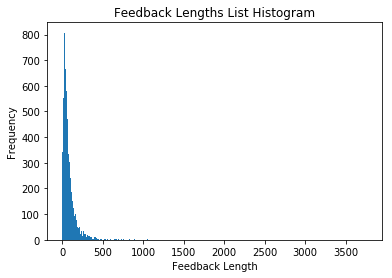

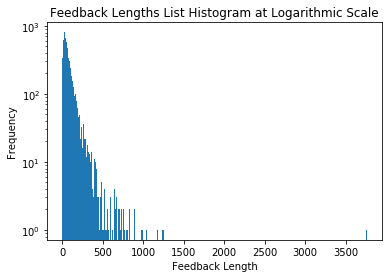

In [9]:
cleanedFeedbacksLegnthList = [len(s) for s in cleanedFeedbacksList]
print('Histogram of feedback lengths:')

fig, ax = plt.subplots()
plt.hist(cleanedFeedbacksLegnthList, bins=500)
plt.title('Feedback Lengths List Histogram')
plt.xlabel('Feedback Length')
plt.ylabel('Frequency')


fig, ax = plt.subplots()
plt.hist(cleanedFeedbacksLegnthList, bins=500)
plt.title('Feedback Lengths List Histogram at Logarithmic Scale')
ax.set_yscale('log')
plt.xlabel('Feedback Length')
plt.ylabel('Frequency')

outlierFeedbackLengthCount = 0.0
outlierCap = 400
for s in cleanedFeedbacksLegnthList:
    if s > outlierCap:
        outlierFeedbackLengthCount = outlierFeedbackLengthCount  + 1

print('Max feedback length is %d and only %d samples have length more than %d (roughly %0.2f%%).' % 
      (max(cleanedFeedbacksLegnthList), outlierFeedbackLengthCount, outlierCap, 
       outlierFeedbackLengthCount/dataListLength * 100))

After removing these outliers, the mean feedback tokens count is 75.29 and standard deviation (std) is 66.54.
To make this project computationally tractible,  we can take a maximum sequence length of [mean + 2*std = 208] to be used as LSTM unrolling length.  To make it eye pleasing we set maxSeqLength to 200


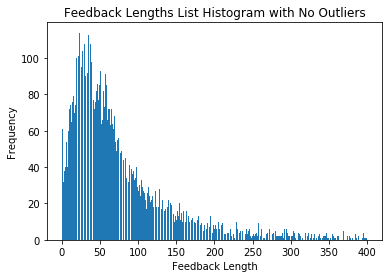

In [10]:
feedbackLegnthListNoOutlier = []
for s in cleanedFeedbacksLegnthList:
    if s < outlierCap:
        feedbackLegnthListNoOutlier.append(s)

fig, ax = plt.subplots()
plt.hist(feedbackLegnthListNoOutlier, bins=500)
plt.title('Feedback Lengths List Histogram with No Outliers')
plt.xlabel('Feedback Length')
plt.ylabel('Frequency')

meanVal = np.mean(feedbackLegnthListNoOutlier)
stdVal = np.std(feedbackLegnthListNoOutlier, axis=0)
print('After removing these outliers, the mean feedback tokens count is %0.2f and standard deviation (std) is %0.2f.' %
      (meanVal, stdVal))

maxSeqLength = int(round(meanVal + 2 * stdVal))
print('To make this project computationally tractible, \
 we can take a maximum sequence length of [mean + 2*std = %d] to be used as LSTM unrolling length. \
 To make it eye pleasing we set maxSeqLength to 200' %
      maxSeqLength)

maxSeqLength = 200

# cleanup memory
feedbackLegnthListNoOutlier = None
cleanedFeedbacksLegnthList = None

### Convert tokens to wordembedding indexes

In [11]:
# feedback wordembedding indexes
# padding is set to zero
ids = np.zeros((len(cleanedFeedbacksList), maxSeqLength), dtype='int32')
for i, tokens in enumerate(cleanedFeedbacksList):
    indexCounter = 0

    for token in tokens:
        if wordsDic.has_key(token):
            ids[i][indexCounter] = wordsDic[token]
        else:
            ids[i][indexCounter] = wordsDic['unk'] # 399999 index of unknown words
        
        indexCounter = indexCounter + 1
        if indexCounter == maxSeqLength:
            break # chop long stories according to mean + 2 * std 

print(type(ids))
print(ids.shape)

<type 'numpy.ndarray'>
(8949, 200)


In [12]:
# test correct indexing from wordembeddings and 'Everything is awesome.'!
print(ids[2])
print(wordsList[1174])
print(wordsList[14])
print(wordsList[13602])
print(wordsList[2])

[  1174     14  13602      2    212    622 201534  14672     20     14
    179    317   4677      4   1265     66    197      4   2432      7
   1287     46   1465   3689     41     33   5042      2     12    189
     30     58      5  11432 201534  17268    873      4     88      2
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      

### Get train/validation/test sets

In [16]:
from sklearn.model_selection import train_test_split
# Create train/test/validation splits
X_train, X_test, y_train, y_test = train_test_split(ids, cleanedTagsList, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [21]:
# test splitting and randomization preserves proper tokens and relevant tags
print(X_test[1])
print(wordsList[11083])
print(wordsList[14663])
print(wordsList[373910])
print(wordsList[1])
print(wordsList[41])
print(y_test[1])

[ 11083  14663 373910      1     41   3476 217470   3814    674    192
   1306 399999    517    363      1     34   6174     47  93325   1650
      6    198      2     61     41   2375 201534   3099     63     14
     84     48   1139    192   1306      2  14663   9215    738      1
     86     81   3832    275    285      2      5     61     69   1712
     10 201534   2858     41  46768    346    102      4    455   3814
    111      4    169     20      2   3124     10    392    275      2
    254   9481      1 399999      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      

### Create multi-hot vectors

In [37]:
def tagToMultiHot(y):
    multiHotArr = np.zeros((len(y), len(sortedCleanedTagTypes)), dtype='int32')

    for idx, val in enumerate(y):
        tempTagsList = val.split(' | ')
        for tempTag in tempTagsList:
            multiHotArr[idx][sortedCleanedTagTypes.index(tempTag)] = 1
    
    return multiHotArr


y_train_multihot = tagToMultiHot(y_train)    
y_test_multihot = tagToMultiHot(y_test)

y_valid_multihot = tagToMultiHot(y_valid)    
y_valid_multihot = tagToMultiHot(y_valid)

y_test_multihot = tagToMultiHot(y_test)    
y_test_multihot = tagToMultiHot(y_test)




In [39]:
print(type(y_test_multihot))
print(y_test_multihot.shape)

# ensure multi-hotting is done right: superhost, sharing, search results,...
print(y_test_multihot[1])

<type 'numpy.ndarray'>
(1790, 63)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0]


### Next step
Now we have word indexes and multi hot, should be able to plu into model and let lookup tab;e look it up and run https://stackoverflow.com/a/39472895